In [52]:
#Choose a Dataset
#Use a pre-annotated dataset for object detection:
#COCO Dataset: Common Objects in Context (80 classes)
#Pascal VOC
#Custom dataset (optional) with annotations in YOLO or COCO format
#from ultralytics import YOLO #How to import a database
#pip install ultralytics


#Install Required Libraries
#pip install opencv-python matplotlib
#pip install tensorflow tensorflow-hub opencv-python matplotlib
#pip install tensorflow scikit-learn opencv-python gTTS




In [74]:
#Import Libraries
import os
import random
import requests
import torch
from PIL import Image
from torch.utils.data import DataLoader

from pathlib import Path

In [60]:
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)



In [61]:
#  Simple configuration class for creating the data set
class config:
    
    # Trainer params
    CHECKPOINT_DIR = '..//ipynb_checkpoints' # Saves checkpoints
    EXPERIMENT_NAME = 'race_number' # Name of the experiment
    
    # Dataset params
    DATA_DIR = './input' # The data directory
    
    # Training set
    TRAIN_IMAGES_DIR =  './train_images' # Train images folder
    TRAIN_LABELS_DIR = "./train_labels" # Train labels folder

    # Validation
    VAL_IMAGES_DIR = './val_images' # Validation images folder
    VAL_LABELS_DIR = './val_labels' # Validation labels folder (array of points)
    
    # Test set
    TEST_IMAGES_DIR = './test_images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = './test_labels' #child dir of DATA_DIR where test labels are (array of points)

    CLASSES = ['free_parking_space','not_free_parking_space','partially_free_parking_space']
    NUM_CLASSES = len(CLASSES)

    # Dataloader params
    DATALOADER_PARAMS={
    'batch_size': 4,
    'num_workers': 2
    }

    # Model params
    MODEL_NAME = 'yolo_nas_l' # yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' # Only one option here: coco

  # Initialize the trainer
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, 
                  ckpt_root_dir=config.CHECKPOINT_DIR)
print(f"Trainer initialized: {trainer}")

#Test
# Set the model to evaluation mode
model.eval()



YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

Trainer initialized: <super_gradients.training.sg_trainer.sg_trainer.Trainer object at 0x0000024A6F190700>


In [62]:
# Test model with a dummy input
dummy_input = torch.randn(1, 3, 640, 640)

# Run the dummy input through the model
output = model(dummy_input)

print("Model output:", output)


Model output: ((tensor([[[-59.8269, -60.4259,  66.6973,  68.6544],
         [-51.3727, -60.2820,  74.5694,  68.5712],
         [-43.4264, -60.2427,  82.6979,  68.5800],
         ...,
         [305.1281, 369.7528, 815.2614, 879.5807],
         [337.1331, 369.7573, 847.2693, 879.5759],
         [369.1239, 369.7768, 879.2531, 879.5709]]], grad_fn=<MulBackward0>), tensor([[[0.0098, 0.0101, 0.0096],
         [0.0102, 0.0101, 0.0098],
         [0.0101, 0.0101, 0.0098],
         ...,
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100]]], grad_fn=<SigmoidBackward0>)), (tensor([[[-4.6162, -4.5848, -4.6377],
         [-4.5779, -4.5859, -4.6190],
         [-4.5848, -4.5852, -4.6145],
         ...,
         [-4.5942, -4.5958, -4.5965],
         [-4.5945, -4.5958, -4.5960],
         [-4.5942, -4.5962, -4.5959]]], grad_fn=<PermuteBackward0>), tensor([[[-0.0354,  0.0866, -0.0767,  ...,  0.0682, -0.1122,  0.0513],
         [-0.0479,  0.1018, -0.0202,

[2025-04-28 00:16:04] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 16/16 [00:00<?, ?it/s]
[2025-04-28 00:16:04] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 8/8 [00:00<00:00, 661.58it/s]
[2025-04-28 00:16:04] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 6/6 [00:00<00:00, 570.78it/s]


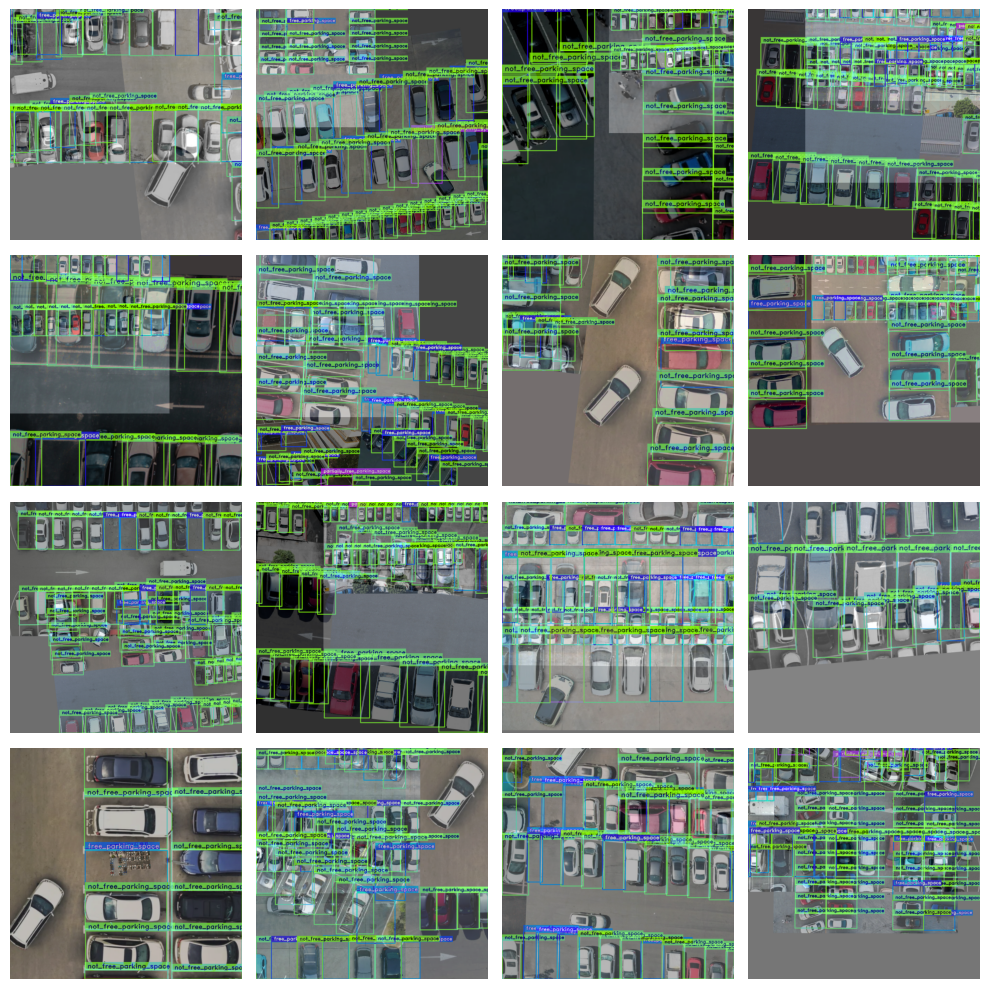

In [63]:
# Creating the dataset
# Split the datat into train, test, and validation sets
# The training dataset
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The validation data set
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The test data set
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

train_data.dataset.plot() # Visualize the test images with plotting




In [64]:
model = models.get(
    "yolo_nas_l",
    num_classes=config.NUM_CLASSES,
    checkpoint_path="model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth",
    load_backbone=True
)

[2025-04-28 00:16:19] INFO - checkpoint_utils.py - Successfully loaded model's backbone weights from model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth checkpoint.


In [76]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [83]:
# Define your metrics
metrics = [DetectionMetrics_050(num_cls=config.NUM_CLASSES)]
print(f"Metrics initialized: {metrics}")



# Define post-prediction callback
post_prediction_callback = PPYoloEPostPredictionCallback(
    score_threshold=0.25,
    nms_top_k=100,
    max_predictions=300,
    nms_threshold=0.7
)

# Example updated training parameters with num_classes passed to PPYoloELoss
training_params = {
    "max_epochs": 25,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "metrics": metrics,
    "loss": PPYoloELoss(num_classes=config.NUM_CLASSES),  # Pass num_classes here
    "optimizer": "Adam",
    "ema": True,
    "mixed_precision": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "warmup_epochs": 3,
    "ckpt_period": 1,
}

# Create DataLoader instances for train and validation
train_loader = DataLoader(train_data, batch_size=config.DATALOADER_PARAMS['batch_size'], num_workers=config.DATALOADER_PARAMS['num_workers'])
val_loader = DataLoader(val_data, batch_size=config.DATALOADER_PARAMS['batch_size'], num_workers=config.DATALOADER_PARAMS['num_workers'])

# Train
trainer.train(
    model=model,
    training_params=training_params,
    train_loader=train_loader,  # Correctly pass the DataLoader
    valid_loader=val_loader    # Correctly pass the validation DataLoader
)



Metrics initialized: [DetectionMetrics_050()]
The console stream is now moved to ..//ipynb_checkpoints\race_number\RUN_20250428_013515_001112/console_Apr28_01_35_15.txt


[2025-04-28 01:35:15] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20250428_013515_001112`
[2025-04-28 01:35:15] INFO - sg_trainer.py - Checkpoints directory: ..//ipynb_checkpoints\race_number\RUN_20250428_013515_001112
[2025-04-28 01:35:15] INFO - sg_trainer.py - Using EMA with params {}
[2025-04-28 01:35:15] WARNING - ema.py - Parameter `decay` is not specified for EMA params. Please specify `decay` parameter explicitly in your config:
ema: True
ema_params: 
  decay: 0.9999
  decay_type: exp
  beta: 15
Will default to decay: 0.9999
In the next major release of SG this warning will become an error.
[2025-04-28 01:35:15] WARNING - ema.py - Parameter decay_type is not specified for EMA model. Please specify decay_type parameter explicitly in your config:
ema: True
ema_params: 
  decay: 0.9999
  decay_type: constant|exp|threshold
Will default to `exp` decay with beta = 15
In the next major release of SG this warning will become an error.
c:\Users\hanna\anaconda3\envs\tf3\li

RuntimeError: DataLoader worker (pid(s) 37028, 29832) exited unexpectedly

[2025-04-27 23:38:29] INFO - checkpoint_utils.py - Successfully loaded model weights from model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth checkpoint.


YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr